# JEF Paper Coding (2024) - v4.4 CRSP (For Monthly Data - Size & inv)

In [22]:
import os

import pandas as pd
from pandas.tseries.offsets import MonthEnd
import numpy as np
import matplotlib.pyplot as plt
import statistics
import datetime
import time

import statsmodels.api as sm
from statsmodels.api import OLS, add_constant
from statsmodels.regression.rolling import RollingOLS
from statsmodels.tsa.stattools import acf
from statsmodels.tools.tools import add_constant
import statsmodels.formula.api as smf
import scipy
from scipy.stats import mstats, stats, norm

from IPython.display import HTML

from scipy.ndimage import uniform_filter
import warnings
warnings.warn = lambda *args,**kwargs: None
warnings.filterwarnings("ignore", category=DeprecationWarning) 

pd.options.display.float_format = '{:20,.4f}'.format

In [23]:
# 0.1 initial value setup
freq = 12  # the frequency of the data <- 12 for monthly; 4 for quarterly; 1 for annually
start_ym = pd.to_datetime("1965-12-31")  # the starting time
end_ym = pd.to_datetime("2023-12-31")  # the ending time

def month_select(freq=freq):
    # return the months for different time frequencies
    if freq == 12:
        return ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
    elif freq == 4:
        return ["March", "June", "September", "December"]
    elif freq == 1:
        return ["December"]

def freq_name(freq=freq):
    if freq == 12:
        return "monthly"
    elif freq == 4:
        return "quarterly"
    elif freq == 1:
        return "annual"

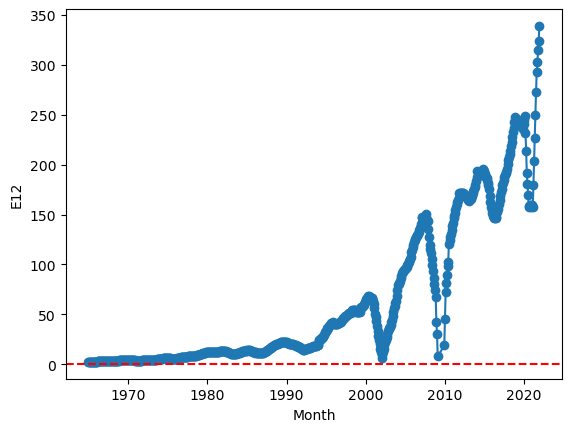

In [24]:
# 0.2 preliminary data cleaning ----

# Read "Variables_DK_CRSP_monthly_196601_201912.csv"
#port_market = pd.read_csv("Variables_DK_CRSP_monthly_196601_201912.csv")
port_market = pd.read_csv("PredictorDataDK_CRSPm.csv")


# Assuming as_tibble() function is not required in Python, proceed with DataFrame

# Perform data cleaning and manipulation
#port_market['E12'] = ((port_market['E12'] * (port_market['E12'] > 0) + 0.001 * (port_market['E12'] <= 0))) * 12 / freq
port_market = port_market[port_market['E12'] > 0]

if freq == 1:
    port_market['month'] = (pd.to_datetime(port_market['yyyy'], format="%Y"))
elif freq ==12:
    port_market['month'] = (pd.to_datetime(port_market['yyyymm'], format="%Y%m"))
    
port_market['vwret'] = np.log(1 + port_market['vwret']).rolling(window=int(12 / freq)).sum()
port_market = port_market[port_market['month'].dt.month_name().isin(month_select(freq=freq))]
port_market = port_market[port_market['month'] < end_ym]

# Plotting
plt.plot(port_market['month'], port_market['E12'], marker='o', linestyle='-')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Month')
plt.ylabel('E12')
plt.show()

# Write to "market_Allfirms.csv"
port_market.to_csv("market_Allfirms.csv", index=False)

# Read "PredictorDataDK_szbm_CRSPm.csv"
#ports_all = pd.read_csv("PredictorDataDK_szbm_CRSPm.csv")
ports_all = pd.read_csv("PredictorDataDK_szinv_CRSPm2.csv")

# Perform data cleaning and manipulation
#ports_all['E12'] = ((ports_all['E12'] * (ports_all['E12'] > 0) + 0.001 * (ports_all['E12'] <= 0))) * 12 / freq
ports_all = ports_all[ports_all['E12'] > 0]
ports_all['month'] = pd.to_datetime(ports_all['date'], format="%Y-%m-%d")
ports_all['vwret'] = np.log(1 + ports_all['vwret']).rolling(window=int(12 / freq)).sum()
ports_all = ports_all[ports_all['month'] <= end_ym]

# Identify unique ports
ports = ports_all['port'].unique()

# Write port data to separate CSV files
for p in ports:
    ports_dt = ports_all[ports_all['port'] == p].sort_values('month').copy()
    ports_dt = ports_dt.drop(columns=['port'])
    ports_dt.to_csv(f"port_{p}.csv", index=False)

port_market = pd.read_csv("PredictorDataDK_CRSPm.csv")

# Assuming as_tibble() function is not required in Python, proceed with DataFrame

# Perform data cleaning and manipulation
#port_market['E12'] = ((port_market['E12'] * (port_market['E12'] > 0) + 0.001 * (port_market['E12'] <= 0))) * 12 / freq
port_market = port_market[port_market['E12'] > 0]

if freq == 1:
    port_market['month'] = (pd.to_datetime(port_market['yyyy'], format="%Y"))
elif freq ==12:
    port_market['month'] = (pd.to_datetime(port_market['yyyymm'], format="%Y%m"))

#port_market['vwret'] = np.log(1 + port_market['vwret_DK']).rolling(window=int(12 / freq)).sum()

In [25]:
port_market

,yyyymm,Index,E12,PE,D12,Y,vwret_DK,b/m,tbl,AAA,...,lty,ntis,Rfree,infl,ltr,corpr,svar,vwret,CRSP_SPvwx,month
0,196501,50.9690,2.3348,21.8298,1.3676,0.0268,0.0381,0.4717,0.0381,0.0443,...,0.0422,0.0179,0.0028,0.0000,0.0040,0.0081,0.0002,0.0348,0.0338,1965-01-01
1,196502,51.1293,2.3828,21.4577,1.3870,0.0271,0.0072,0.4714,0.0393,0.0441,...,0.0424,0.0148,0.0030,0.0000,0.0014,0.0009,0.0004,0.0037,-0.0009,1965-02-01
2,196503,50.5616,2.4078,20.9992,1.3930,0.0276,-0.0102,0.4695,0.0393,0.0442,...,0.0422,0.0191,0.0036,0.0032,0.0054,0.0012,0.0001,-0.0122,-0.0137,1965-03-01
3,196504,52.2070,2.4300,21.4846,1.3997,0.0268,0.0340,0.4526,0.0393,0.0443,...,0.0422,0.0147,0.0031,0.0032,0.0036,0.0021,0.0002,0.0356,0.0348,1965-04-01
4,196505,51.6646,2.4556,21.0397,1.4075,0.0272,-0.0039,0.4547,0.0389,0.0444,...,0.0423,0.0162,0.0031,0.0000,0.0018,-0.0008,0.0003,-0.0031,-0.0084,1965-05-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679,202108,"8,940.0436",292.7657,30.5365,170.0235,0.0190,0.0289,0.1848,0.0005,0.0255,...,0.0128,0.0148,0.0000,0.0021,-0.0035,-0.0045,0.0006,0.0306,0.0292,2021-08-01
680,202109,"8,551.8859",303.4407,28.1831,169.6271,0.0198,-0.0440,0.1930,0.0004,0.0253,...,0.0137,0.0156,0.0000,0.0027,-0.0250,-0.0194,0.0014,-0.0461,-0.0472,2021-09-01
681,202110,"9,113.6144",315.0298,28.9294,170.5967,0.0187,0.0666,0.1824,0.0005,0.0268,...,0.0158,0.0134,0.0000,0.0083,0.0051,0.0159,0.0012,0.0705,0.0696,2021-10-01
682,202111,"8,970.9061",324.1544,27.6748,170.9168,0.0191,-0.0152,0.1895,0.0005,0.0262,...,0.0156,0.0156,0.0001,0.0049,0.0210,0.0094,0.0013,-0.0073,-0.0087,2021-11-01


In [26]:
# 0.3 name portfolios and predictors ----

# List files matching patterns
market_names = [file for file in os.listdir('.') if file.startswith('market_')]
data_names = [file for file in os.listdir('.') if file.startswith('port_')]

# Assuming 'ports' is a list containing identifiers for portfolios
id_names = np.append("Market", ports)

# List of potential predictors
ratio_names = ["DP", "PE", "EY", "DY", "Payout"]

#### Figure 1 - Log Cumulative Index

Log cumulative realised portfolio return components for seven portfolios - the market portfolio and six size and book-to-market equity ratio sorted portfolios. All following figures decmonstrate the monthly realised price-earnings ratio growth (gm), earnings growth (ge), dividend-price (dp) and the portfolio return index (r) with the values in January 1966 as zero for all portfolios.

market_Allfirms.csv


<Figure size 550x350 with 0 Axes>

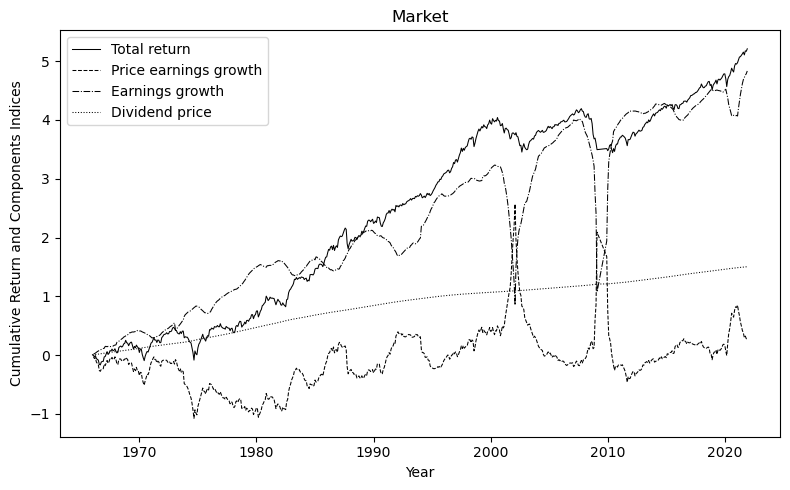

port_BA.csv


<Figure size 550x350 with 0 Axes>

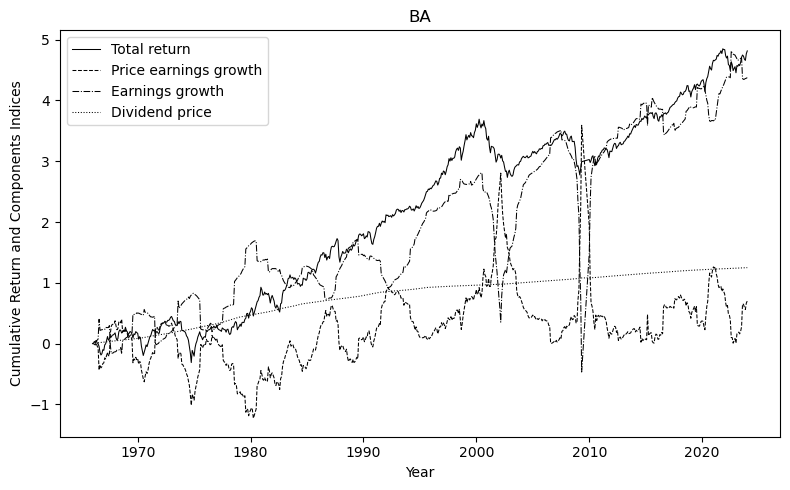

port_BC.csv


<Figure size 550x350 with 0 Axes>

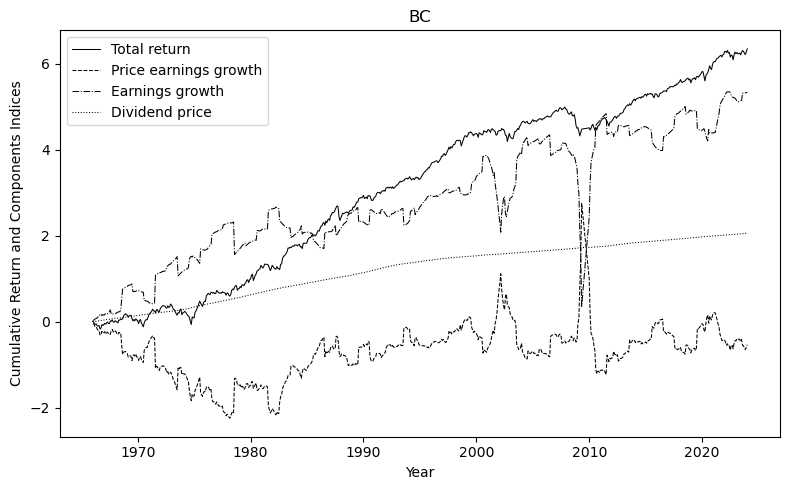

port_BN.csv


<Figure size 550x350 with 0 Axes>

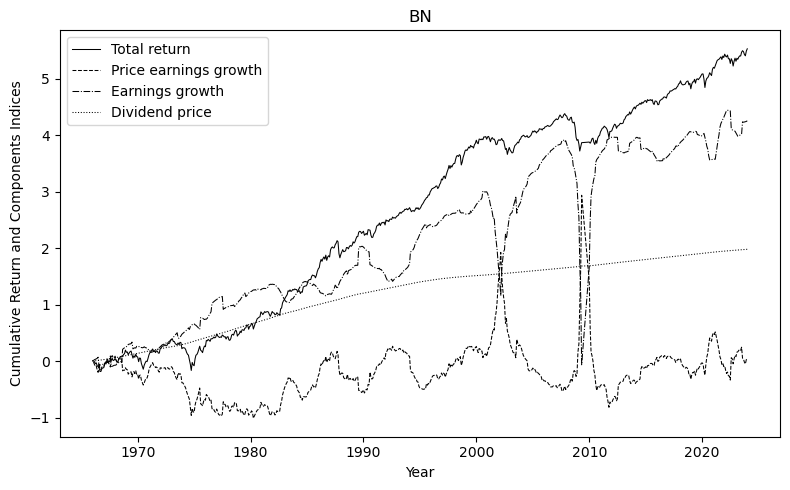

port_SA.csv


<Figure size 550x350 with 0 Axes>

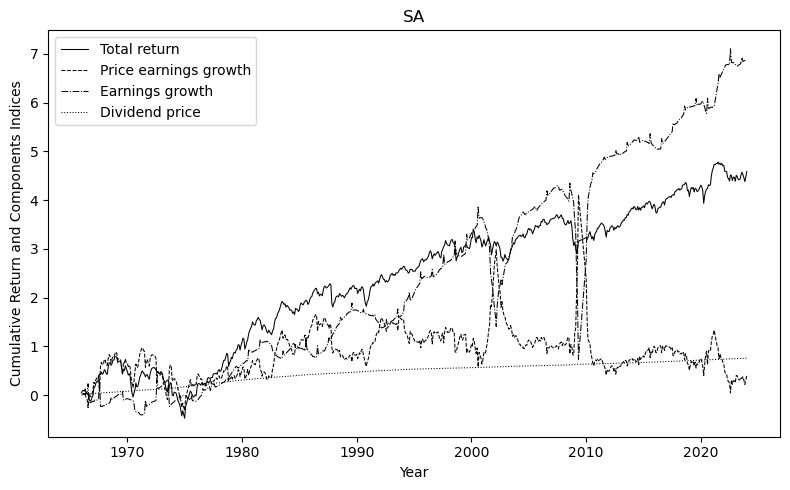

port_SC.csv


<Figure size 550x350 with 0 Axes>

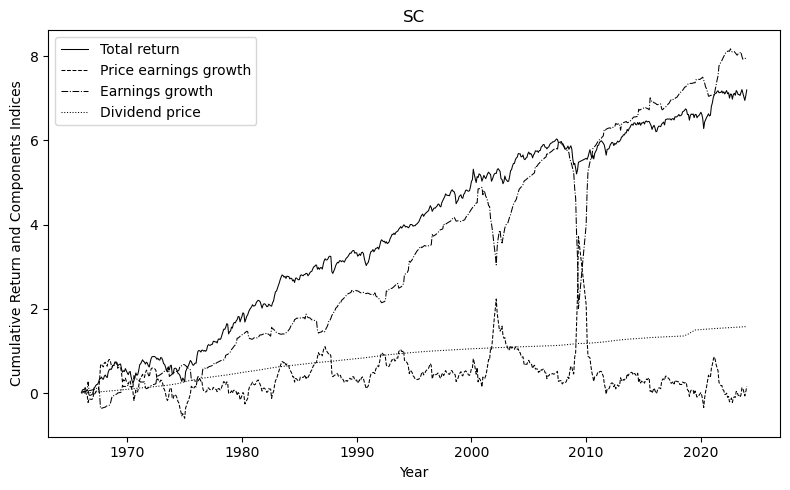

port_SN.csv


<Figure size 550x350 with 0 Axes>

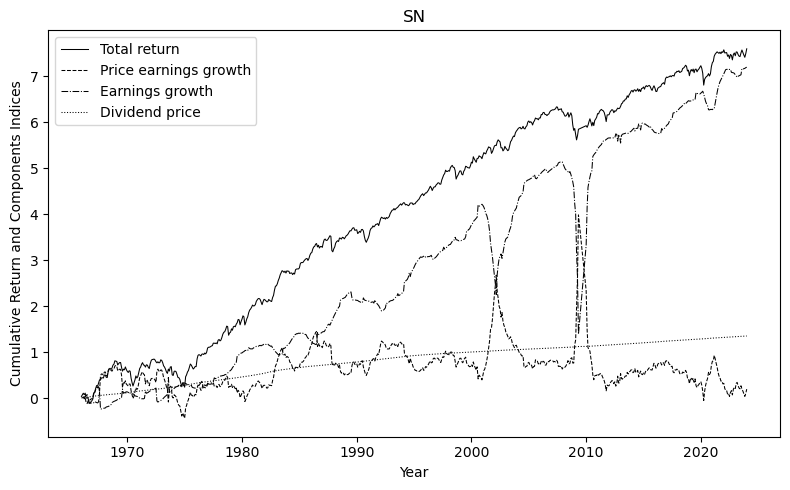

In [27]:
# TABLE-1. summary statistics
TABLE1_uni = {}  # Dictionary for univariate statistics
TABLE1_cor = {}  # Dictionary for correlation matrices

PE_df = pd.DataFrame({'month': port_market['month'][port_market['month'] >= start_ym]})
EY_df = pd.DataFrame({'month': port_market['month'][port_market['month'] >= start_ym]})
DP_df = pd.DataFrame({'month': port_market['month'][port_market['month'] >= start_ym]})

# (1*) summary tables for Summary & Correlations
for c in range(0,7):
    id = market_names[c] if c < len(market_names) else data_names[c - len(market_names)]
    print(id)

    # 1. Read the data
    data_nyse = pd.read_csv(id)
    data_nyse['month'] = pd.to_datetime(data_nyse['month'], format="%Y-%m-%d")
    data_nyse = data_nyse[data_nyse['month'] >= start_ym]

    data_nyse.rename(columns={'vwret':'r', 'D12': 'D', 'Index': 'P', 'E12': 'E'}, inplace=True)
    
    # Select relevant columns and compute additional metrics
    data_nyse['DP'] = data_nyse['D'] / data_nyse['P']
    data_nyse['PE'] = data_nyse['P'] / data_nyse['E'].rolling(6).mean()
    data_nyse['PE'] = data_nyse['P'] / data_nyse['E']
    data_nyse['EP'] = data_nyse['E'] / data_nyse['P']
    data_nyse['EY'] = data_nyse['E'] / data_nyse['P'].shift(1)
    data_nyse['DY'] = data_nyse['D'] / data_nyse['P'].shift(1)
    data_nyse['Payout'] = data_nyse['D'] / data_nyse['E']

    # Update the respective DataFrames
    PE_df[id] = data_nyse['PE']
    EY_df[id] = data_nyse['EY']
    DP_df[id] = data_nyse['DP']

    # 2. Return decomposition
    data_decompose = data_nyse.copy()

    # Define lagged columns
    data_decompose['lag_PE'] = data_decompose['PE'].shift()
    data_decompose['lag_E'] = data_decompose['E'].shift()

    # Compute columns
    data_decompose['gm'] = np.log(data_decompose['PE']) - np.log(data_decompose['lag_PE'])
    data_decompose['ge'] = np.log(data_decompose['E']) - np.log(data_decompose['lag_E'])
    #data_decompose['ge'] = np.log(data_decompose['E']) - np.log(data_decompose['lag_E']).rolling(6).mean()
    data_decompose['dp'] = np.log((1 + data_decompose['DP']))/freq
    
    # Drop rows with NaN values resulting from lagging
    #data_decompose = data_decompose.dropna()

    # 3. summary-Stat ----
    def ar1_coef(x):
        return float(sm.OLS(x, sm.add_constant(x.shift()), missing='drop').fit().params[1])

    # Compute summary statistics
    #comp_summary_dt = data_decompose[['gm', 'ge', 'dp', 'r']].describe().T

    gm = data_decompose.agg({'gm' : ['mean','median', 'std','min', 'max', 'skew', 'kurt']}).T
    ge = data_decompose.agg({'ge' : ['mean','median', 'std','min', 'max', 'skew', 'kurt']}).T
    dp = data_decompose.agg({'dp' : ['mean','median', 'std','min', 'max', 'skew', 'kurt']}).T
    r = data_decompose.agg({'r' : ['mean','median', 'std','min', 'max', 'skew', 'kurt']}).T

    comp_summary_dt = pd.concat([gm, ge, dp, r])

    comp_summary_dt['mean'] *= 100
    comp_summary_dt['std'] *= 100
    comp_summary_dt['median'] *= 100
    comp_summary_dt['min'] *= 100
    comp_summary_dt['max'] *= 100
    comp_summary_dt.rename(columns={'mean': 'Mean', 'median': 'Median', 'std': 'SD', 'min':'Min', 'max':'Max',
                                   'skew':'Skew', 'kurt':'Kurt'}, inplace=True)
    comp_summary_dt = comp_summary_dt[['Mean', 'Median', 'SD', 'Min', 'Max', 'Skew', 'Kurt']].round(2)

    #print(comp_summary_dt)
    # Compute AR(1) coefficients
    ar1_coeffs = data_decompose[['gm', 'ge', 'dp', 'r']].apply(ar1_coef)
    comp_summary_dt['AR(1)'] = ar1_coeffs

    # 4. Compute correlations
    comp_summary_dt[['gm', 'ge', 'dp', 'r']] = data_decompose[['gm', 'ge', 'dp', 'r']].corr()

    # Store the summary statistics
    TABLE1_uni[id_names[c]] = comp_summary_dt

    # Figure-1. cumulative realised return components ----
    plt.figure(figsize=(5.5, 3.5))
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2)
    linestyles = ['-', '--', '-.', ':']
    
    cum_components = data_decompose[['r', 'gm', 'ge', 'dp']].apply(np.cumsum)
    cum_components.index = data_decompose['month']
    
    # Plot cumulative return components with different linestyles
    plt.figure(figsize=(8, 5))
    for i, column in enumerate(cum_components.columns):
        plt.plot(cum_components.index, cum_components[column], linestyle=linestyles[i], c='black', linewidth=0.75)

    plt.title(id_names[c])
    plt.xlabel('Year')
    plt.ylabel('Cumulative Return and Components Indices')
    plt.legend(["Total return", "Price earnings growth", "Earnings growth", "Dividend price"], loc='upper left', fontsize='medium')
    plt.tight_layout()
    
    plt.show()

### Table 1 - Summary statistics of return components

The correlations between gm and ge might be a bit too high comparing to Ferreira and Santa-Clara (2011). Need to check the code again.

In [28]:
from tabulate import tabulate
import pandas as pd

# Define the data
data = []

# Display the table with the note

display(HTML(f"<center><h2>Table 1 - Summary statistics of return components</h2></center>"))
display(HTML(f"<p><center>{freq_name(freq)} data starts from {data_decompose['month'].iloc[0]} and ends in {data_decompose['month'].iloc[-1]}.</p>"))


# Iterate over each data frame in TABLE1_uni
for key, df in TABLE1_uni.items():
    table_data = df.round(decimals=2).values.tolist()
    headers = list(df.columns)
    table = tabulate(table_data, headers=headers, tablefmt='html')
    display(HTML('<center> {}'.format(key)))
    display(HTML('<center> {}'.format(table)))

# Generate the note
note = f"Note: Panel A in this table presents mean, median, standard deviation (SD), minimum, maximum, skewness (Skew), kurtosis (kurt) and first-order autocorrelation coefficient of the realised components of stock market returns and six size and book-to-market equity ratio sorted portfolios. These univariate statistics for each portfolios are presented separately. gm is the continuously compounded growth rate in the price-earnings ratio. ge is the continuously compounded growth rate in earnings. dp is the log of one plus the dividend-price ratio. *r* is the portfolio returns."
display(HTML(f"<p>{note}</p>"))

Mean,Median,SD,Min,Max,Skew,Kurt,AR(1),gm,ge,dp,r
0.04,0.02,9.4,-92.16,123.16,1.61,62.58,0.27,1,-0.86,0.03,0.4
0.73,0.97,9.07,-134.17,88.79,-2.1,104.74,0.27,-0.86,1,-0.07,0.08
0.23,0.22,0.08,0.08,0.45,0.35,-0.41,0.99,0.03,-0.07,1,-0.04
0.79,1.19,4.35,-24.31,15.54,-0.66,2.5,0.03,0.4,0.08,-0.04,1


Mean,Median,SD,Min,Max,Skew,Kurt,AR(1),gm,ge,dp,r
0.1,0.01,13.4,-164.63,131.73,-1.24,51.16,0.15,1,-0.92,-0,0.38
0.64,0.84,12.92,-120.53,194.72,3.56,90.62,0.14,-0.92,1,-0.03,0.01
0.18,0.15,0.11,0.01,0.52,0.93,0.12,0.98,-0,-0.03,1,-0.05
0.7,1.02,5.3,-26.94,19.95,-0.54,1.93,0.05,0.38,0.01,-0.05,1


Mean,Median,SD,Min,Max,Skew,Kurt,AR(1),gm,ge,dp,r
-0.08,-0.17,14.29,-175.71,128.84,-1.53,48.52,0.12,1,-0.95,0.04,0.32
0.77,1.01,14.19,-120.51,208.41,3.45,80.2,0.13,-0.95,1,-0.05,-0.02
0.3,0.28,0.13,0.12,0.7,0.56,-0.78,0.98,0.04,-0.05,1,-0.01
0.92,1.18,4.42,-23.13,17.81,-0.44,1.97,0.03,0.32,-0.02,-0.01,1


Mean,Median,SD,Min,Max,Skew,Kurt,AR(1),gm,ge,dp,r
0.01,-0.08,11.51,-151.36,127.56,-1.35,72.41,0.18,1,-0.93,-0,0.36
0.62,0.88,11.16,-120.05,172.16,3.24,110.13,0.21,-0.93,1,-0.02,-0
0.29,0.26,0.14,0.09,0.59,0.51,-1.1,0.99,-0,-0.02,1,-0.03
0.8,1.07,4.17,-21.24,14.2,-0.66,2.26,0.01,0.36,-0,-0.03,1


Mean,Median,SD,Min,Max,Skew,Kurt,AR(1),gm,ge,dp,r
0.06,0.14,14.37,-172.06,136.65,-1.28,44.55,0.06,1,-0.89,-0.01,0.44
1,1.19,13.5,-120.61,203.47,3.65,88,0.04,-0.89,1,-0.03,0.03
0.11,0.09,0.06,0.04,0.29,0.93,-0.12,0.97,-0.01,-0.03,1,-0.06
0.66,1.19,6.64,-38.2,24.86,-0.8,3.07,0.14,0.44,0.03,-0.06,1


Mean,Median,SD,Min,Max,Skew,Kurt,AR(1),gm,ge,dp,r
0.02,0.01,12.87,-161.84,138.81,-1.15,59.95,0.16,1,-0.87,-0.01,0.46
1.16,1.14,12.05,-120.44,197.47,4.65,123.85,0.17,-0.87,1,-0.04,0.02
0.23,0.2,0.16,0.06,1.43,3.92,21.79,0.93,-0.01,-0.04,1,-0.06
1.04,1.55,6.2,-35.68,24.84,-0.64,3.22,0.13,0.46,0.02,-0.06,1


Mean,Median,SD,Min,Max,Skew,Kurt,AR(1),gm,ge,dp,r
0.03,0.1,12.36,-164.46,134.37,-1.61,70.83,0.15,1,-0.9,0.03,0.4
1.04,1.08,11.82,-120.63,193.59,4.53,125.62,0.16,-0.9,1,-0.06,0.03
0.2,0.17,0.09,0.07,0.52,0.93,0.64,0.97,0.03,-0.06,1,-0.04
1.1,1.64,5.36,-30.78,22.62,-0.86,3.63,0.12,0.4,0.03,-0.04,1


### Figure 3 - Cumulative OOS R-square Difference and Cumulative SSE Difference

The cumulative OOS R-square figures show the out-of-sample cumulative R-square up to each month from predictive regressions with listed predictors and from the sum-of-the-parts (SOP) method for each portfolio. The cumulative SSE difference plots indicates the out-of-sample performance of each model. These are evaluated by the cumulative squared prediction errors of the NULL minus the cumulative squared predictirion error of the ALTERNATIVE. The NULL model is the historical mean model, while the ALTERNATIVE model is either the predictive regression model or the SOP model. An increase in the line suggests better performance of the ALTERNATIVE model and a decrease suggests that the NULL model is better.

##### Several points to note in the coding:
1. The dividend-price ratio (‘DP’ hereafter) is calculated as the log of 1 plus the frequency-adjusted dividend to price ratio, rather than using the annual dividend. As by this return decomposition, the expected amount of dividend payout in each period should be adjusted by the frequency of the data in the analysis. \[ dp_t = \log (1 + \frac{\tilde{D}_t}{P_t}) = \log (1 + \frac{D_t / n}{P_t}) \text{,} \] where \(D_t\) is the annual dividend payment and \(n\) is the data frequency (e.g. \(n = 1\) for annual data and \(n = 12\) for monthly data) and \(\tilde{D}_t\) is the freqency-adjusted dividend payment for period \(t\).
2. The SOP method by Ferreira and Santa-Clara (2011) decomposes the portfolio return into three components, namely the earnings growth, the prie multiple expansion and the next period dividend-price ratio. Here to generate the SOP prediction, we use the rolling mean of past earnings growth as the expected growth of the next period (denoted as ge1). However, there are other choices, such as recursive means in ge2 and ge3.3. critica.value = TRUE is the option whether to use boostrap method to calculate the MSE-F critical values. This is used in function Boot_MSE.F.
4. The authors should evaluate the significance of the MSE−F statistic by using the theoret- ical distribution derived in McCracken (2007). The bootstrap-based inference (presented in Pages 9-10) can represent a robustness check and moved to an appendix. Further- more, the authors can also include in the main results the related out-of-sample statistic proposed by Clark and West (2007), which follows a standard Normal distribution. Therefore, readjust the Boot_MSE.F function.
5. Column McCracken in Table 2 (line 604) gives the significance of the out-of-sample \(MSE–F\) statistic of McCracken (2007). \(***\), \(**\), and \(*\) denote significance at the 1%, 5%, and 10% level, respectively. Please refer to the Table 4 on P749 in McCracken (2007) with \(k_2 = 1\) and \(\pi = P/R = \frac{\text{Number of out-of-sample forecasts}}{\text{Number of observations used to form the first forecast}} = 1.6\).

- Examples are in P742-743. See https://estima.com/procs/CLARKFORETESTDOC.PDF


Market: SOP
662


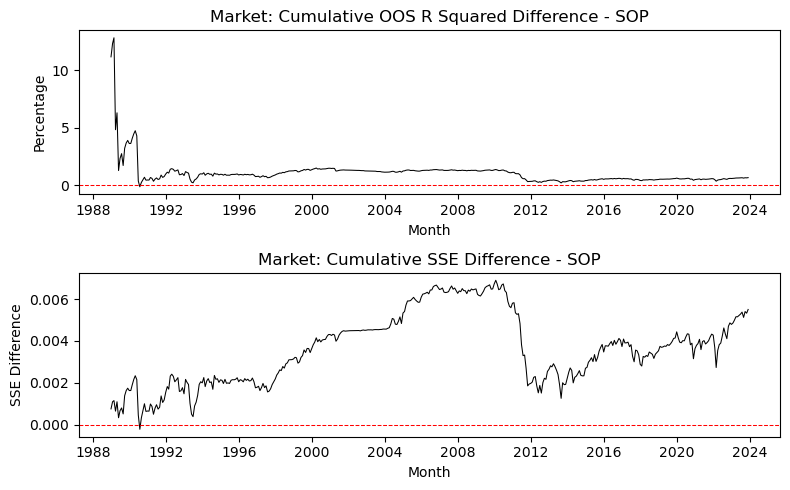

Market: DP
IS R Squared: 0.007252
OOS R Squared: -0.009082
MAE-A: 0.03353
MSE-F: -3.797971


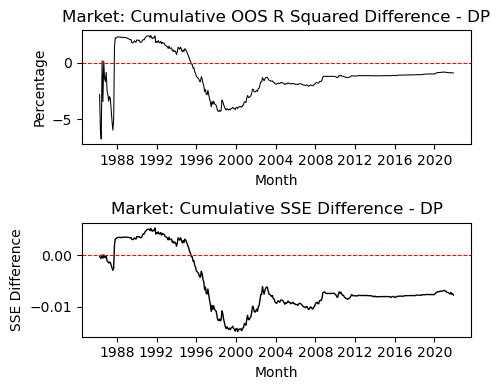

Market: PE
IS R Squared: 0.007826
OOS R Squared: 0.001676
MAE-A: 0.032998
MSE-F: 0.70825


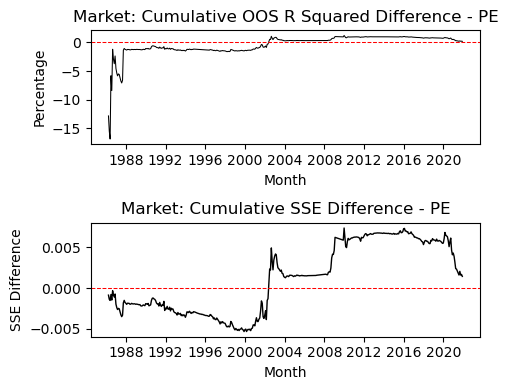

Market: EY
IS R Squared: 0.008438
OOS R Squared: 0.001055
MAE-A: 0.033025
MSE-F: 0.44588


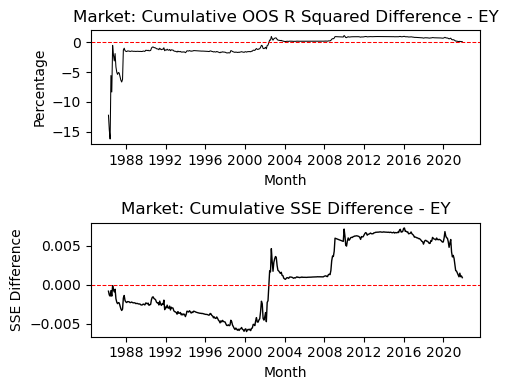

Market: DY
IS R Squared: 0.007995
OOS R Squared: -0.011321
MAE-A: 0.0336
MSE-F: -4.724086


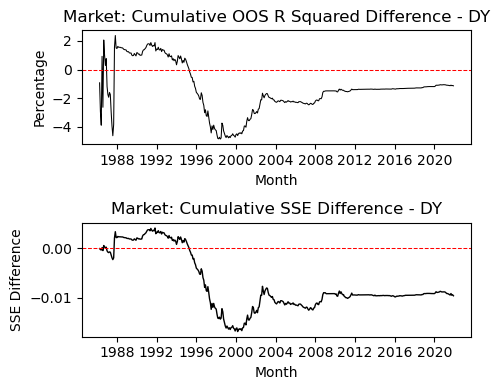

Market: Payout
IS R Squared: 0.000736
OOS R Squared: -0.00966
MAE-A: 0.032659
MSE-F: -4.037315


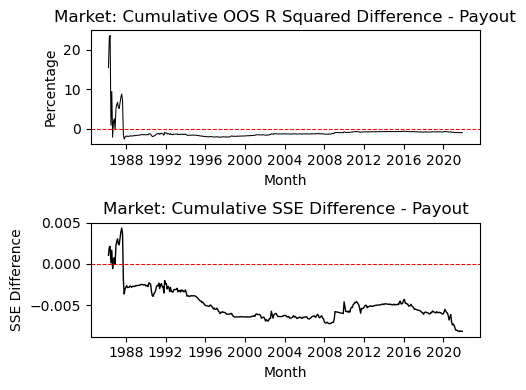

BA: SOP
688


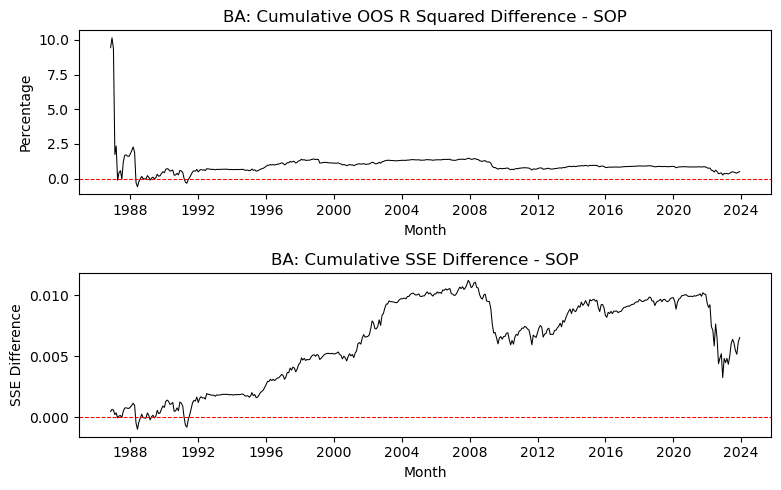

BA: DP
IS R Squared: 0.002216
OOS R Squared: -0.007945
MAE-A: 0.040552
MSE-F: -3.531488


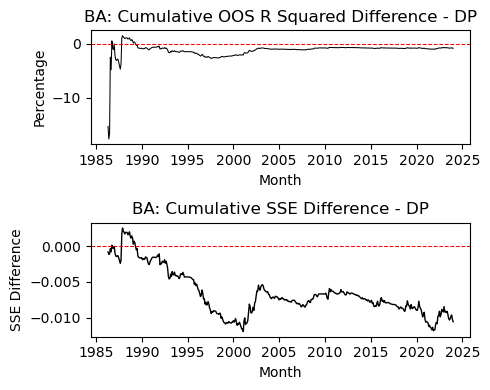

BA: PE
IS R Squared: 0.003783
OOS R Squared: -0.000238
MAE-A: 0.040345
MSE-F: -0.106793


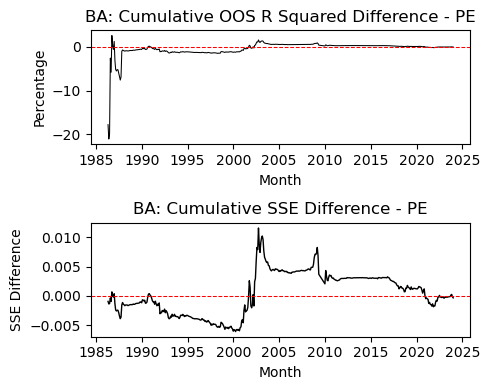

BA: EY
IS R Squared: 0.004326
OOS R Squared: -0.00203
MAE-A: 0.040408
MSE-F: -0.907759


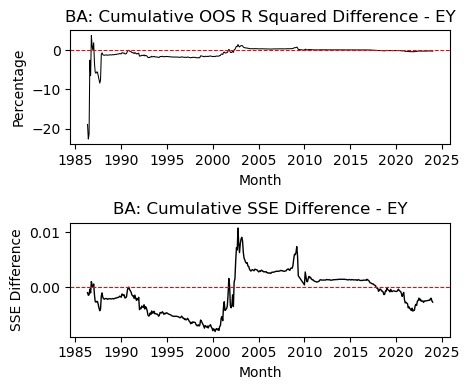

BA: DY
IS R Squared: 0.002626
OOS R Squared: -0.011164
MAE-A: 0.040695
MSE-F: -4.946144


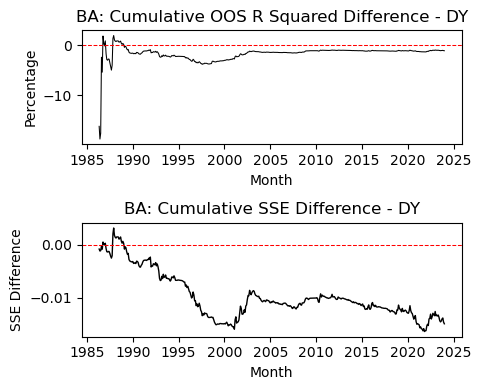

BA: Payout
IS R Squared: 0.000222
OOS R Squared: -0.002259
MAE-A: 0.040013
MSE-F: -1.009939


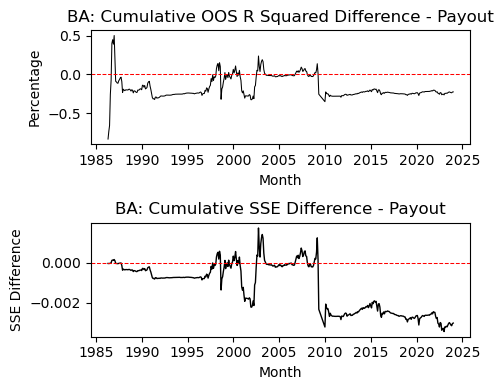

BC: SOP
688


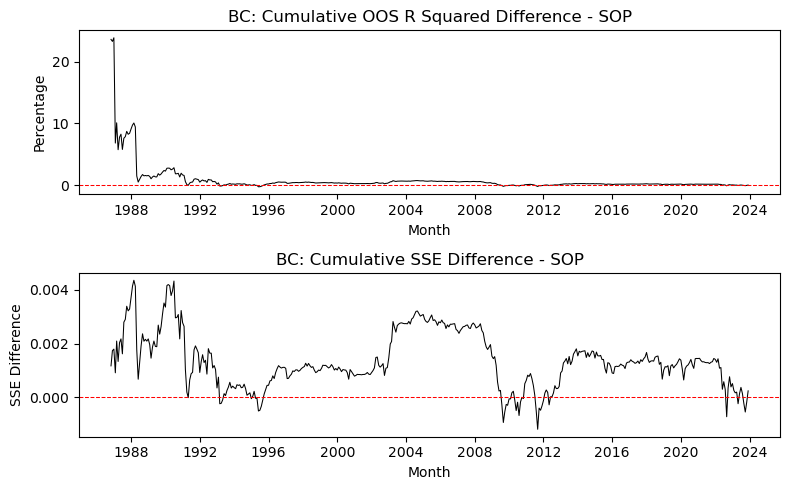

BC: DP
IS R Squared: 0.006221
OOS R Squared: -0.008001
MAE-A: 0.032832
MSE-F: -3.555837


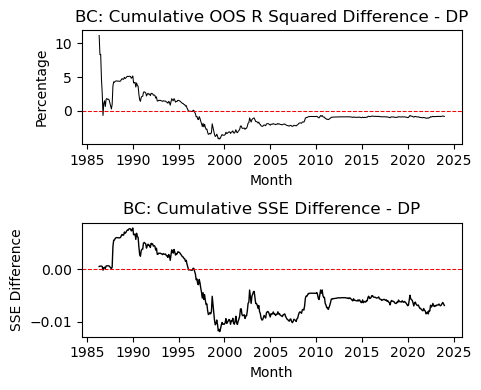

BC: PE
IS R Squared: 0.002115
OOS R Squared: -0.003035
MAE-A: 0.032574
MSE-F: -1.355537


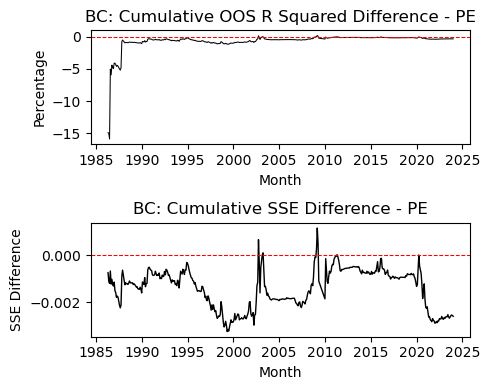

BC: EY
IS R Squared: 0.002075
OOS R Squared: -0.00372
MAE-A: 0.032563
MSE-F: -1.660457


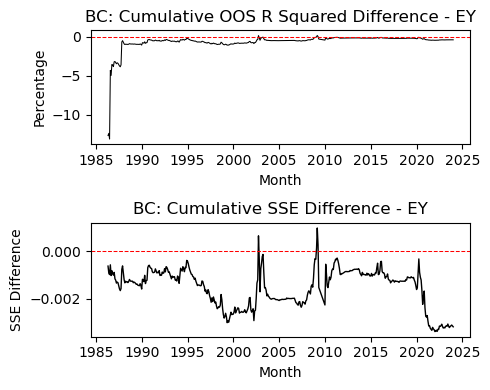

BC: DY
IS R Squared: 0.006488
OOS R Squared: -0.010046
MAE-A: 0.032862
MSE-F: -4.455898


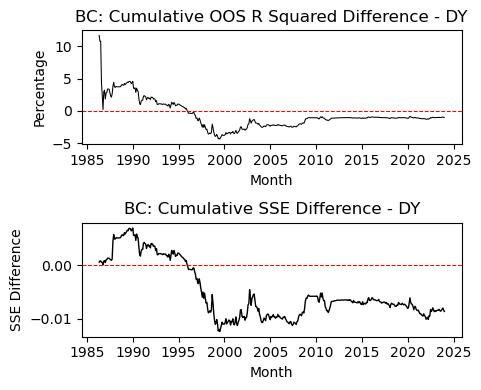

BC: Payout
IS R Squared: 0.000317
OOS R Squared: -0.002748
MAE-A: 0.03234
MSE-F: -1.227787


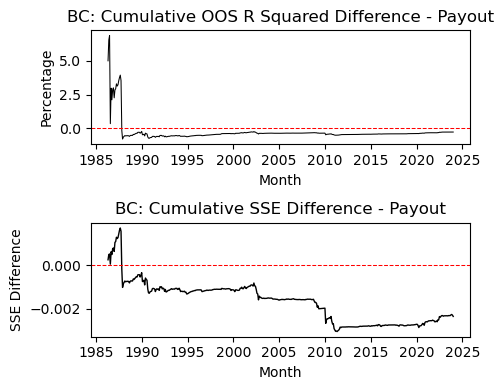

BN: SOP
688


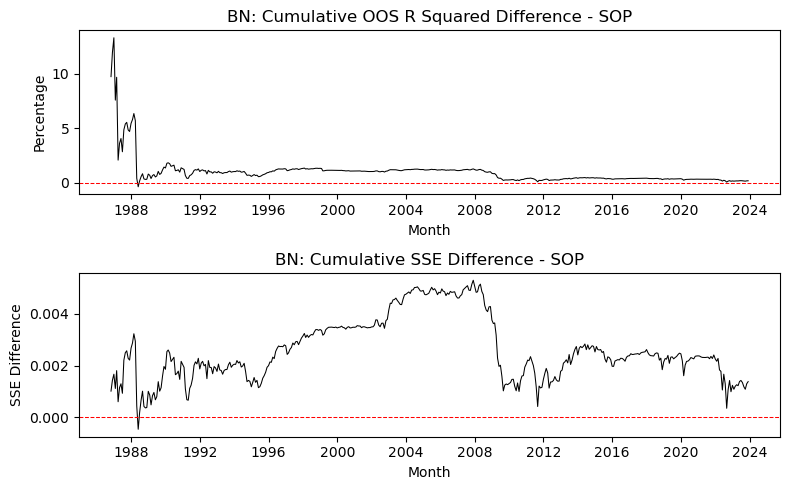

BN: DP
IS R Squared: 0.002034
OOS R Squared: -0.00791
MAE-A: 0.031992
MSE-F: -3.516036


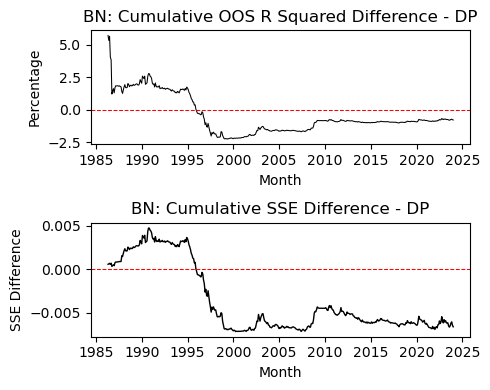

BN: PE
IS R Squared: 0.003044
OOS R Squared: -0.005014
MAE-A: 0.03173
MSE-F: -2.235094


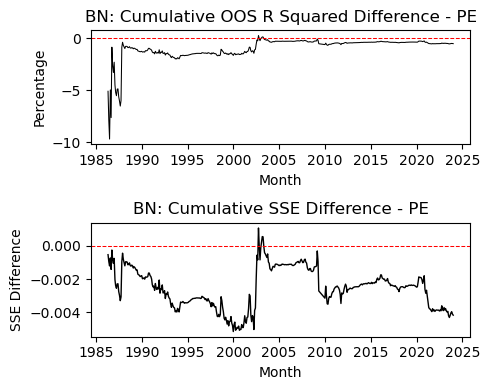

BN: EY
IS R Squared: 0.003126
OOS R Squared: -0.006312
MAE-A: 0.031752
MSE-F: -2.81023


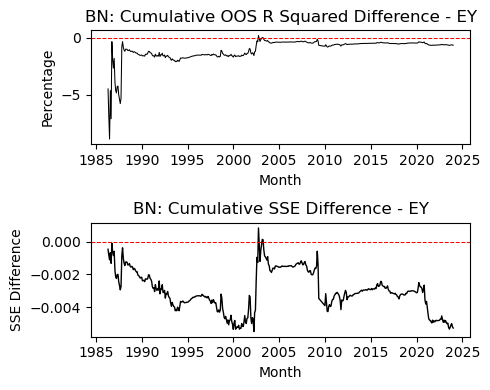

BN: DY
IS R Squared: 0.002084
OOS R Squared: -0.008722
MAE-A: 0.032016
MSE-F: -3.873781


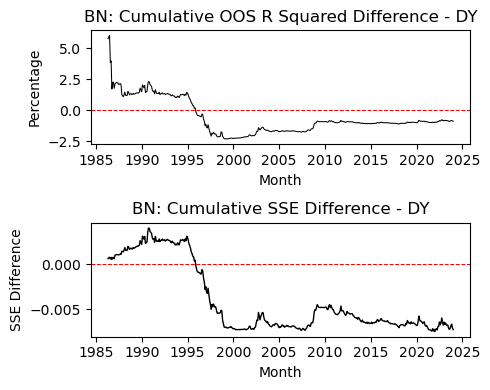

BN: Payout
IS R Squared: 1e-05
OOS R Squared: -0.008556
MAE-A: 0.031419
MSE-F: -3.800519


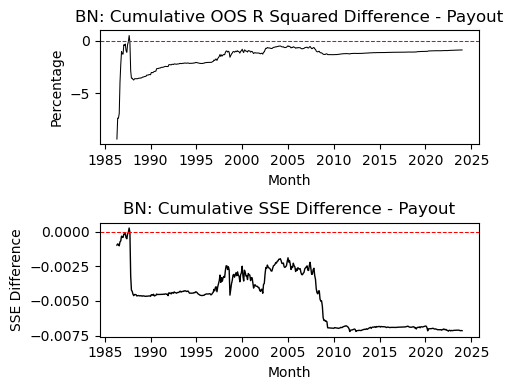

SA: SOP
688


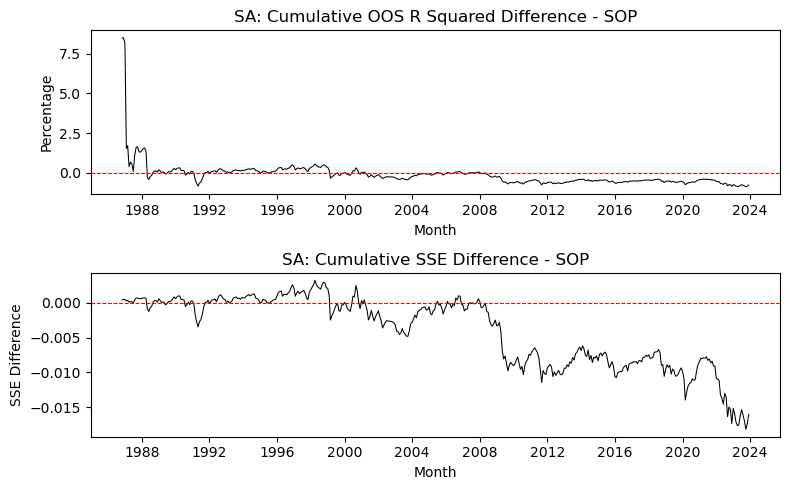

SA: DP
IS R Squared: 0.002342
OOS R Squared: -0.007346
MAE-A: 0.05014
MSE-F: -3.26721


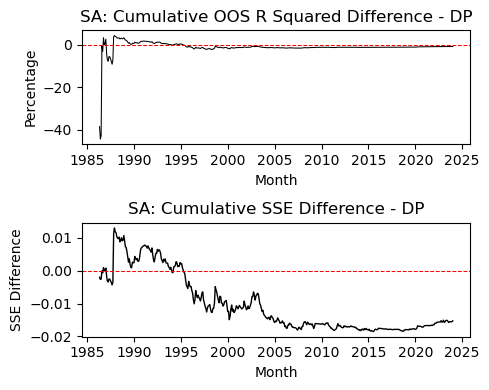

SA: PE
IS R Squared: 0.000726
OOS R Squared: -0.003507
MAE-A: 0.049207
MSE-F: -1.56573


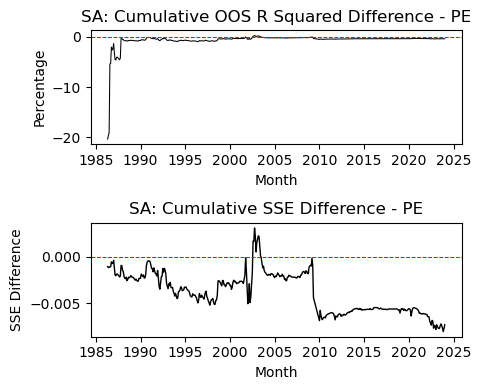

SA: EY
IS R Squared: 0.002236
OOS R Squared: -0.005917
MAE-A: 0.049417
MSE-F: -2.635367


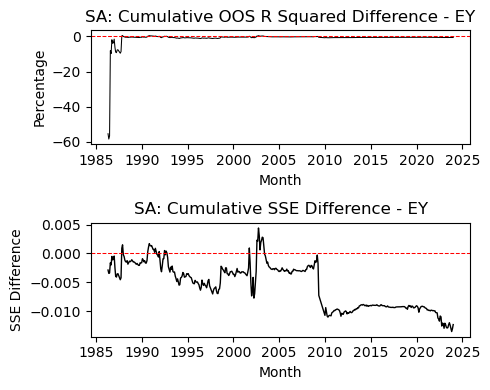

SA: DY
IS R Squared: 0.00439
OOS R Squared: -0.016578
MAE-A: 0.050837
MSE-F: -7.305714


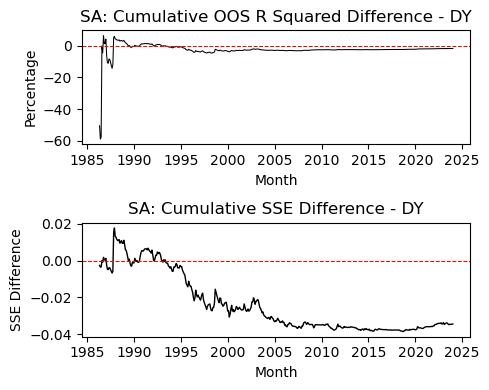

SA: Payout
IS R Squared: 0.00069
OOS R Squared: -0.010879
MAE-A: 0.049195
MSE-F: -4.821458


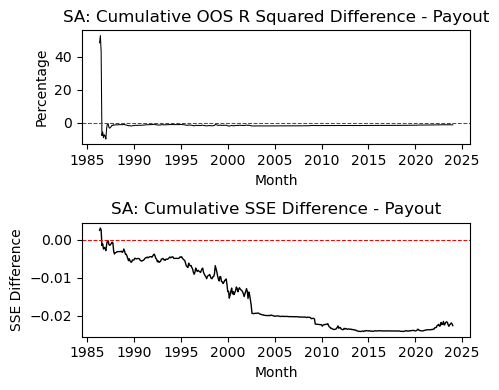

SC: SOP
688


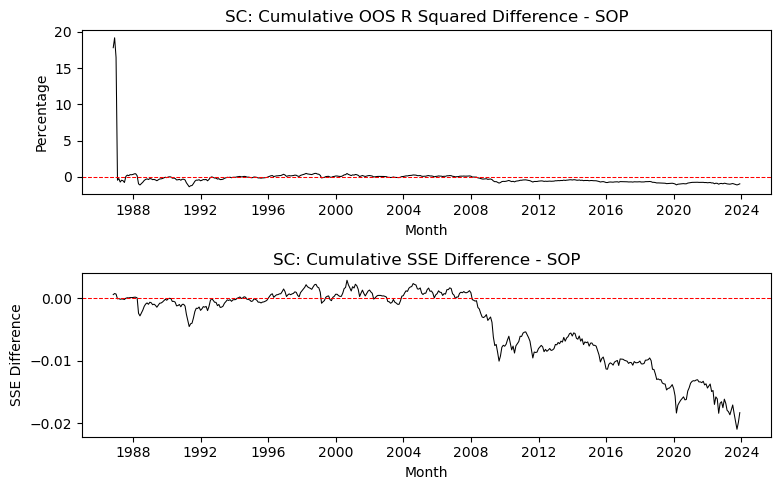

SC: DP
IS R Squared: 0.001394
OOS R Squared: -0.00861
MAE-A: 0.047045
MSE-F: -3.824338


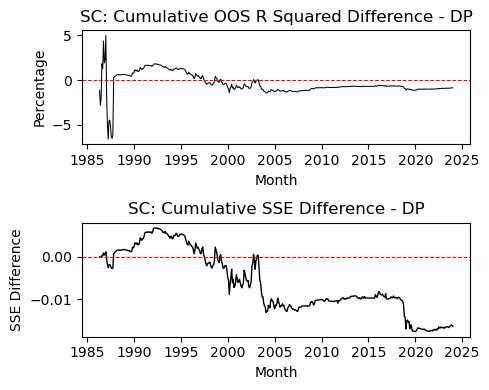

SC: PE
IS R Squared: 0.000154
OOS R Squared: -0.009021
MAE-A: 0.046883
MSE-F: -4.005455


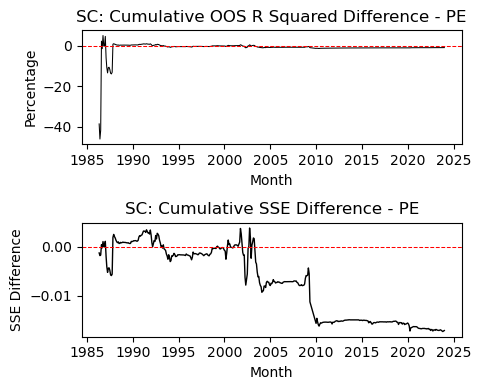

SC: EY
IS R Squared: 0.001001
OOS R Squared: -0.014969
MAE-A: 0.047104
MSE-F: -6.607024


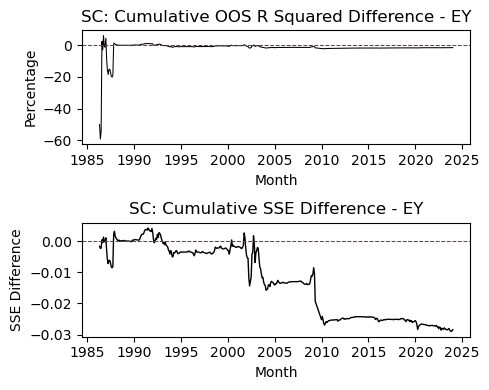

SC: DY
IS R Squared: 0.002618
OOS R Squared: -0.01321
MAE-A: 0.047346
MSE-F: -5.841006


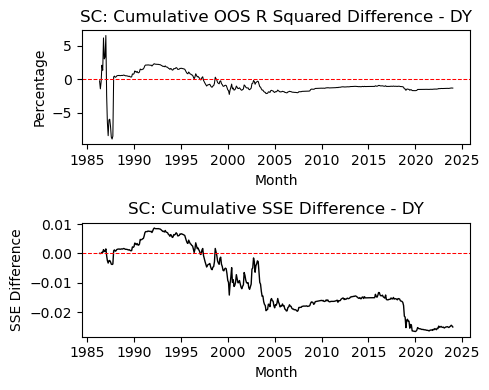

SC: Payout
IS R Squared: 0.000876
OOS R Squared: -0.007587
MAE-A: 0.046681
MSE-F: -3.373496


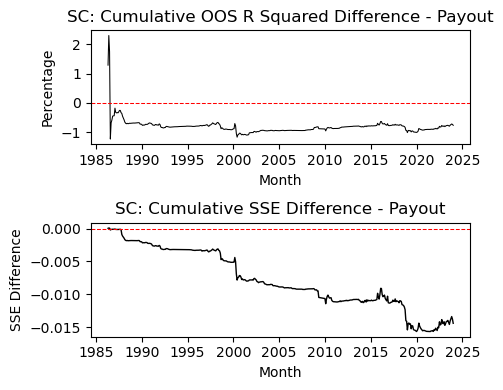

SN: SOP
688


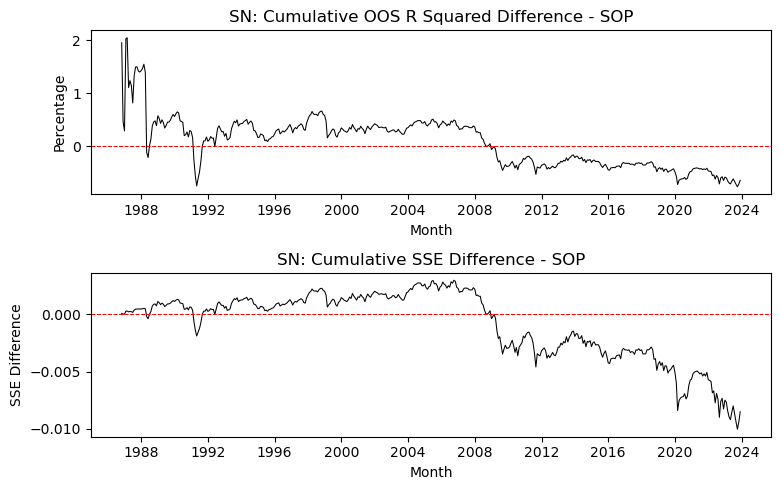

SN: DP
IS R Squared: 0.006732
OOS R Squared: -0.004494
MAE-A: 0.039627
MSE-F: -2.004488


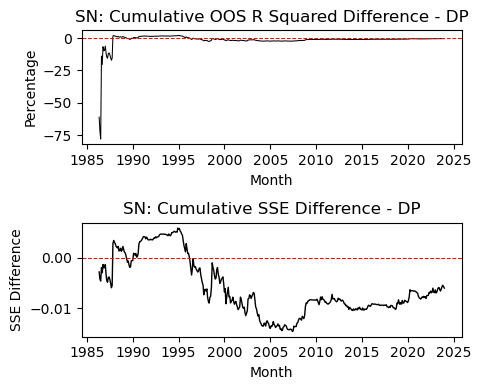

SN: PE
IS R Squared: 1.4e-05
OOS R Squared: -0.005579
MAE-A: 0.038996
MSE-F: -2.485689


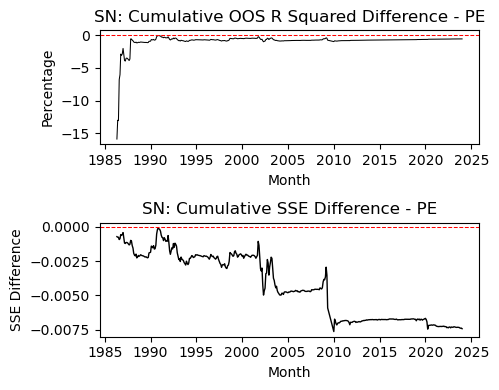

SN: EY
IS R Squared: 0.000279
OOS R Squared: -0.007587
MAE-A: 0.039145
MSE-F: -3.3732


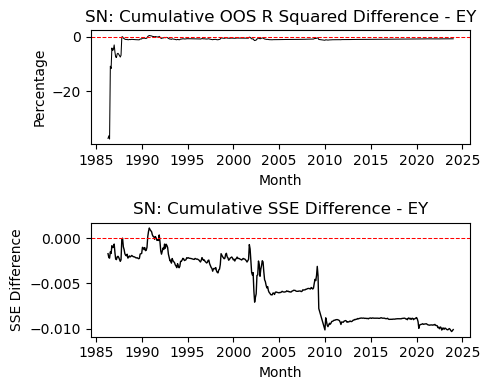

SN: DY
IS R Squared: 0.00902
OOS R Squared: -0.012391
MAE-A: 0.040018
MSE-F: -5.483147


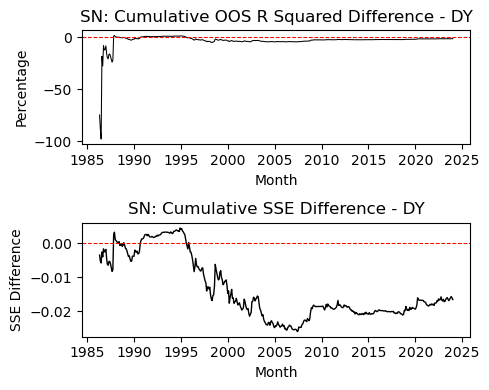

SN: Payout
IS R Squared: 0.005249
OOS R Squared: -0.004586
MAE-A: 0.038889
MSE-F: -2.044992


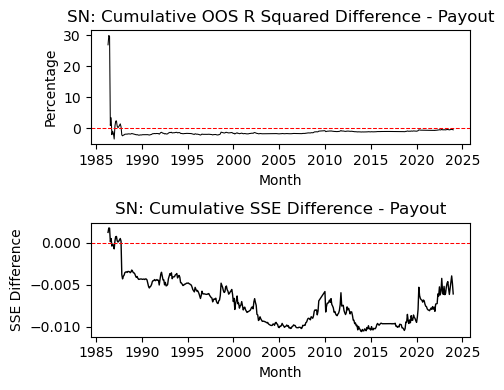

In [29]:
import pandas as pd
import numpy as np
from statsmodels.regression.rolling import RollingOLS
from scipy.stats import percentileofscore

TABLE2_pred = {} #Dictionary of results by portfolio

# Define a function to calculate cumulative mean squared error (MSE)
def cum_mean_squared_error(errors):
    cum_mse = np.cumsum(errors ** 2)
    return cum_mse / np.arange(1, len(errors) + 1)

# Define a function to calculate out-of-sample R-squared
def oos_r_squared(actual, predicted):
    mse_actual = np.mean((actual - predicted) ** 2)
    mse_naive = np.mean((actual - np.mean(actual)) ** 2)
    return 1 - (mse_actual / mse_naive)

# Define a function to perform bootstrap
def bootstrap_mse_f(data, actual, cond, uncond, x, size, subset, boot_times=10000):
    ports_dt = data[['month', actual, cond, uncond, x, 'IS_r_squared']].copy()

    # Clean and reorganize the data
    ports_dt_narm = ports_dt.dropna(subset=['month', actual, cond, uncond, x])
    
    ports_dt_narm['error_A'] = ports_dt_narm[actual] - ports_dt_narm[cond]
    ports_dt_narm['error_N'] = ports_dt_narm[actual] - ports_dt_narm[uncond]
    ports_dt_narm['Cuml_MSE_A'] = ports_dt_narm['error_A'].pow(2).expanding().mean()
    ports_dt_narm['Cuml_MSE_N'] = ports_dt_narm['error_N'].pow(2).expanding().mean()
    ports_dt_narm['Cuml_OOS.rsquared'] = 1 - ports_dt_narm['Cuml_MSE_A'] / ports_dt_narm['Cuml_MSE_N']
    ports_dt_narm['Cum_SSE'] = (ports_dt_narm['error_N'].pow(2) - ports_dt_narm['error_A'].pow(2)).cumsum()

    MSE_A = (ports_dt_narm['error_A']**2).mean()
    MSE_N = (ports_dt_narm['error_N']**2).mean()
    OOS_r_squared = 1 - MSE_A / MSE_N
    MSE_F = len(ports_dt_narm) * (MSE_N - MSE_A) / MSE_A
    MAE_A = ports_dt_narm['error_A'].abs().mean()
    
    if x == 'mu_sop':
        IS_r_squared = np.nan
        x = 'SOP'
    else:
        IS_r_squared = ports_dt_narm['IS_r_squared'].reset_index(drop=True)[0]
        
    print("IS R Squared:", round(IS_r_squared, 6))
    print("OOS R Squared:", round(OOS_r_squared, 6))
    print("MAE-A:", round(MAE_A, 6))
    print("MSE-F:", round(MSE_F, 6))

    Cuml_OOS_rsquared = ports_dt_narm.set_index('month')[['Cuml_OOS.rsquared']]
    Cuml_SSE = ports_dt_narm.set_index('month')[['Cum_SSE']]

    # Plotting
    if size == 'large':
        plt.figure(figsize=(8, 5))
        plt.subplot(2, 1, 1)

    elif size == 'small':
        plt.figure(figsize=(5, 4))
        plt.subplot(2, 1, 1)
        
    plt.plot((Cuml_OOS_rsquared * 100)[2:], linewidth=0.75, color='black')
    plt.axhline(y=0, color='r', linestyle='--', linewidth=0.75)
    plt.xlabel('Month')
    plt.ylabel('Percentage')
    plt.title(f'{subset}: Cumulative OOS R Squared Difference - {x}')

    plt.subplot(2, 1, 2)
    plt.plot(Cuml_SSE[2:], linewidth=1, color='black')
    plt.axhline(y=0, color='r', linestyle='--', linewidth=0.75)
    plt.xlabel('Month')
    plt.ylabel('SSE Difference')
    plt.title(f'{subset}: Cumulative SSE Difference - {x}')

    plt.tight_layout()
    plt.show()   
    return {
        'Predictor': x,
        'IS_r_squared': IS_r_squared,
        'OOS_r_squared': OOS_r_squared,
        'MAE_A': MAE_A,
        'MSE_F': MSE_F
    }

def OOS_SOP(df, xvar, yvar, frequency, subset, start=196601, end=202312, estimation=20):

    OOS_error_N = []
    OOS_error_A = []
    act_ERP = []

    if frequency=='monthly':
        start = df['yyyymm'][df['yyyymm'] == start].index[0]
        
        try:
            end = df['yyyymm'][df['yyyymm'] == end].index[0]
        except:
            end = df.tail(1).index[0]
            print(end)
            
        est_periods_OOS = estimation*12
        
    if frequency=='annual':
        start = df['yyyy'][df['yyyy'] == start].index[0]
        end = df['yyyy'][df['yyyy'] == end].index[0]
        est_periods_OOS = estimation

    df['e_ge'] = df['ge'].rolling(estimation*12).mean()
    df['e_dp'] = np.log(((df['D']/df['P'])/12)+1)

    for i in range(start+est_periods_OOS, end):

        #Get the actual ERP that you want to predict
        actual_ERP = df.iloc[i+1][yvar]
        act_ERP.append(actual_ERP)
    
        # 1. Historical Mean Model
        predicted_m = df.iloc[start:i][yvar].mean()
        _oos_error_n = (actual_ERP - predicted_m)
        OOS_error_N.append(_oos_error_n)
        
        # 2. OLS Model            
        intercept = df.iloc[start:i+1]['ge'].rolling(est_periods_OOS).mean().loc[i] 
        x = (df.loc[start:i-1]['e_dp']).tolist()
        y = (df.loc[start+1:i][yvar]).tolist() - intercept  
        data = pd.DataFrame({'y': y, 'x': x})

        reg_OOS = smf.glm('y ~ x - 1', data = data, offset=-1*data['x'], missing='drop').fit()
        # Compute Error        
        b = reg_OOS.params.iloc[0]
        X = df.iloc[i:i+1]['e_dp'][i]
        pred_ERP = intercept + (b*X)
        error = pred_ERP - actual_ERP
        OOS_error_A.append(error) 
    
    T = len(df)
    s0 = est_periods_OOS
    MSE_N = (sum([x**2 for x in OOS_error_N]))/(T-s0)
    MSE_A = (sum([x**2 for x in OOS_error_A]))/(T-s0)
    try:
        R2 = 1 - (MSE_A/MSE_N)
    except ZeroDivisionError:
        R2 = 0
        
    MAE_A = statistics.mean([abs(x) for x in OOS_error_A]) 
    MSE_F = ((MSE_N-MSE_A)/(MSE_A))*(T-s0)

    Cuml_MSE_A = (pd.DataFrame(OOS_error_A)**2).expanding().mean()
    Cuml_MSE_N = (pd.DataFrame(OOS_error_N)**2).expanding().mean()
    Cuml_OOS_rsquared = 1 - Cuml_MSE_A / Cuml_MSE_N
    Cuml_SSE = ((pd.DataFrame(OOS_error_N)**2) - (pd.DataFrame(OOS_error_A)**2)).cumsum()
  
    d = (xvar.upper(), '{}'.format(R2*100))    
    outsample_sop.append(d)

    # Plotting
    plt.figure(figsize=(8, 5))
    plt.subplot(2, 1, 1)
        
    plt.plot(pd.date_range(end='12/2023', freq='ME', periods=len(Cuml_OOS_rsquared)-2), (Cuml_OOS_rsquared * 100)[2:], linewidth=0.75, color='black')
    plt.axhline(y=0, color='r', linestyle='--', linewidth=0.75)
    plt.xlabel('Month')
    plt.ylabel('Percentage')
    plt.title(f'{subset}: Cumulative OOS R Squared Difference - SOP')

    plt.subplot(2, 1, 2)
    plt.plot(pd.date_range(end='12/2023', freq='ME', periods=len(Cuml_SSE)-2), Cuml_SSE[2:], linewidth=0.75, color='black')
    plt.axhline(y=0, color='r', linestyle='--', linewidth=0.75)
    plt.xlabel('Month')
    plt.ylabel('SSE Difference')
    plt.title(f'{subset}: Cumulative SSE Difference - SOP')

    plt.tight_layout()
    plt.show() 

    return {'Predictor': 'SOP', 'OOS_r_squared':R2, 'MAE_A': MAE_A, 'MSE_F': MSE_F}

# Define the start and end years for data filtering
start_year = 1966
end_year = 2023

# Define a function to read and preprocess the data
def read_and_preprocess_data(file_path):
    data = pd.read_csv(file_path)
    data['month'] = pd.to_datetime(data['month'])
    data = data[(data['month'].dt.year >= start_year) & (data['month'].dt.year <= end_year)]
    data['r'] = np.log(data['vwret']+1)
    return data.reset_index(drop=True)

# Read data for each portfolio
table2 = {}
table2_df = pd.DataFrame()

for c in range(0,7):
    id = market_names[c] if c < len(market_names) else data_names[c - len(market_names)]
    print(f'{id_names[c]}: SOP')
    # Read and preprocess the data
    data_nyse = read_and_preprocess_data(id)
    data_nyse.rename(columns={'Index': 'P', 'E12': 'E', 'D12': 'D'}, inplace=True)
    data_nyse['DP'] = data_nyse['D'] / data_nyse['P']
    data_nyse['PE'] = data_nyse['P'] / data_nyse['E']
    data_nyse['EP'] = data_nyse['E'] / data_nyse['P']
    data_nyse['EY'] = data_nyse['E'] / data_nyse['P'].shift(1)
    data_nyse['DY'] = data_nyse['D'] / data_nyse['P'].shift(1)
    data_nyse['Payout'] = data_nyse['D'] / data_nyse['E']/12

    # Return decomposition
    data_decompose = data_nyse.copy()
    data_decompose['gm'] = np.log(data_decompose['PE']) - np.log(data_decompose['PE'].shift(1))
    data_decompose['ge'] = np.log(data_decompose['E']) - np.log(data_decompose['E'].shift(1))
    data_decompose['dp'] = np.log(1 + data_decompose['DP'] / 12)

    # SOP predictions
    k = 12 * 20  # 20-year rolling window
    data_pred = data_decompose.copy()
    data_pred['mu_gm'] = 0
    data_pred['mu_ge1'] = data_pred['ge'].rolling(window=k, min_periods=1).mean()
    data_pred['mu_ge2'] = data_pred['ge'].rolling(window=k, min_periods=1).mean().shift(k - 1)
    data_pred['mu_ge3'] = data_pred['ge'].expanding(min_periods=1).mean()
    data_pred['mu_dp'] = data_pred['dp']
    data_pred['mu_sop'] = data_pred['mu_gm'] + data_pred['mu_ge1'] + data_pred['mu_dp']
    data_pred['sop_simple'] = data_pred['mu_sop'].shift(1)
    data_pred['hist_mean'] = data_pred['r'].expanding(min_periods=k).mean().shift(1)
    data_pred['IS_r_squared'] = np.nan

    # Cond
    outsample_sop = []
    sop_result = pd.DataFrame(OOS_SOP(data_pred, 'dp', 'r', 'monthly', subset=id_names[c]), index=[id_names[c]])

    # Prepare data for univariate predictive regressions

    #data_decompose['DP'] = np.log(data_decompose['D']) - np.log(data_decompose['P'])
    
    ratio_names = ["DP", "PE", "EY", "DY", "Payout"]  # Define ratio names
    table2_uni_predictors = pd.DataFrame()

    for predictor in ratio_names:
        print(f'{id_names[c]}: {predictor}')
        data_univariate = data_decompose[['month', 'r', predictor]].copy()
        
        data_univariate['hist_mean'] = data_univariate['r'].shift(1).expanding().mean()
        data_univariate['x'] = np.log(data_univariate[predictor]).shift(1)

        # IS R2
        X = sm.add_constant(data_univariate['x'])
        lm_IS = sm.OLS(data_univariate['r'], X, missing='drop').fit()
        IS_r_squared = lm_IS.rsquared
        IS_pval = lm_IS.pvalues  # p-value from F-statistic

        data_univariate['IS_r_squared'] = IS_r_squared

        # OOS recursive window predictions
        con_pred = [np.nan] * len(data_univariate)

        for t in range(k, len(data_univariate)-1):
            y_IS = np.array(data_univariate['r'].loc[0:t-1])
            x_IS = np.array(sm.add_constant(data_univariate['x']).loc[0:t-1])

            # Create and fit model
            reg_OOS = OLS(y_IS, x_IS, missing='drop').fit()

            # Extract the last observed x value for forecasting
            x_new = data_univariate['x'].loc[t]

            a = reg_OOS.params[0]
            b = reg_OOS.params[1]

            # Predict the next value
            y_pred = a+(b*x_new)

            # Store the prediction
            con_pred[t+1] = y_pred

        data_univariate['con_pred'] = con_pred

            # Store the summary statistics

        # Stat and Bootstrap

        stat_bootstrap_result = bootstrap_mse_f(data_univariate, 'r', 'con_pred', 'hist_mean', predictor, boot_times=1000*10, size='small', subset=id_names[c])
        
        # Store the results for all predictors
        table2_uni_predictors = pd.concat([table2_uni_predictors, pd.DataFrame(stat_bootstrap_result, index=[id])])

        TABLE2_pred[id_names[c]] = table2_uni_predictors

        TABLE2_pred[id_names[c]] = pd.concat([TABLE2_pred[id_names[c]], sop_result])
    
    # Statistics summary
    table2_combined = pd.concat([table2_uni_predictors, pd.DataFrame(sop_result)])
    if 'p.value' in table2_combined.columns:
        table2_combined['star'] = np.where(table2_combined['p.value'] <= 0.01, '***',
                                           np.where(table2_combined['p.value'] <= 0.05, '**',
                                                    np.where(table2_combined['p.value'] <= 0.1, '*', '')))
    table2_combined['McCracken'] = np.where(table2_combined['MSE_F'] >= 3.838, '***',
                                             np.where(table2_combined['MSE_F'] >= 1.599, '**',
                                                      np.where(table2_combined['MSE_F'] >= 0.685, '*', '')))
    table2_df = pd.concat([table2_df, table2_combined.assign(rowname=table2_combined.index, portname=id)], ignore_index=True)

### Table 2 - Forecasts of portfolio returns

This table demonstrates the in-sample and out-of-sample R-squares for the market and six size and book-to-market equity ratio sorted portfolios from predictive regressions and the Sum-of-the-Parts method. IS R-squares are estimated using the whole sample period and the OOS R-squares are calculated compare the forecast error of the model against the historical mean model. The full sample period starts from Jan 1966 to December 2019 and the IS period is set to be 20 years with forecsats beginning in Jan 1986. The MSE-F statistics are calculated to test the hypothesis \(H_0: \text{out-of-sample R-squares} = 0\) vs \(H_1: \text{out-of-sample R-squares} \neq 0\).

###### Predictors here are all in log terms.

In [21]:
# Define the data
data = []

# Display the table with the note

display(HTML(f"<center><h2>Table 2 - Forecasts of portfolio returns</h2></center>"))
display(HTML(f"<p><center>{freq_name(freq)} data starts from {data_decompose['month'].iloc[0]} and ends in {data_decompose['month'].iloc[-1]}.</p>"))


# Iterate over each data frame in TABLE1_uni
for key, df in TABLE2_pred.items():
    table_data = df.round(decimals=6).values.tolist()
    headers = list(df.columns)
    table = tabulate(table_data, headers=headers, tablefmt='html')
    display(HTML('<center> {}'.format(key)))
    display(HTML('<center> {}'.format(table)))

Predictor,IS_r_squared,OOS_r_squared,MAE_A,MSE_F
DP,0.007252,-0.009082,0.03353,-3.79797
PE,0.007826,0.001676,0.032998,0.70825
EY,0.008438,0.001055,0.033025,0.44588
DY,0.007995,-0.011321,0.0336,-4.72409
Payout,0.000736,-0.00966,0.032659,-4.03732
SOP,nan,0.006478,0.032004,2.75816


Predictor,IS_r_squared,OOS_r_squared,MAE_A,MSE_F
DP,0.001487,-0.00976,0.039349,-4.09805
PE,0.003296,-0.001416,0.039142,-0.599434
EY,0.003947,-0.003483,0.039212,-1.47184
DY,0.001932,-0.013467,0.039503,-5.63406
Payout,0.000491,-0.002067,0.038762,-0.874566
SOP,nan,0.0084,0.038315,3.60006


Predictor,IS_r_squared,OOS_r_squared,MAE_A,MSE_F
DP,0.005233,-0.010734,0.032174,-4.50296
PE,0.001943,-0.003682,0.031879,-1.55551
EY,0.001966,-0.004303,0.031866,-1.81661
DY,0.005635,-0.012748,0.032201,-5.33713
Payout,0.000174,-0.00331,0.03163,-1.39865
SOP,nan,0.001825,0.031199,0.776941


Predictor,IS_r_squared,OOS_r_squared,MAE_A,MSE_F
DP,0.001689,-0.008985,0.031225,-3.7759
PE,0.003213,-0.005151,0.030935,-2.17275
EY,0.003445,-0.00637,0.030955,-2.68389
DY,0.001832,-0.009747,0.031249,-4.093
Payout,0.00011,-0.009137,0.030607,-3.83893
SOP,nan,0.003132,0.030164,1.33516


Predictor,IS_r_squared,OOS_r_squared,MAE_A,MSE_F
DP,0.002018,-0.00849,0.049386,-3.56933
PE,0.001003,-0.003185,0.048335,-1.34598
EY,0.002824,-0.005113,0.048529,-2.15693
DY,0.004019,-0.018313,0.050133,-7.62514
Payout,0.000376,-0.012124,0.048402,-5.07888
SOP,nan,-0.004684,0.047604,-1.9813


Predictor,IS_r_squared,OOS_r_squared,MAE_A,MSE_F
DP,0.001081,-0.009886,0.045812,-4.1508
PE,0.000224,-0.00956,0.04563,-4.01487
EY,0.001327,-0.015496,0.045857,-6.47006
DY,0.002305,-0.014859,0.04613,-6.20789
Payout,0.000575,-0.008834,0.04543,-3.71287
SOP,nan,-0.007811,0.044769,-3.29398


Predictor,IS_r_squared,OOS_r_squared,MAE_A,MSE_F
DP,0.005915,-0.006529,0.038661,-2.75042
PE,7e-05,-0.005887,0.037932,-2.48134
EY,0.000524,-0.007745,0.038081,-3.25877
DY,0.008306,-0.014829,0.039079,-6.19559
Payout,0.004349,-0.006652,0.037903,-2.80174
SOP,nan,-0.004114,0.037326,-1.74147
